In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import json
import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')

%matplotlib inline
viz.notebook_full_width()

In [10]:
dataset = reader.load_dataset(constants.MASS_SS_NAME, params={pkeys.FS: 200})
fs = dataset.fs

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


In [11]:
filter_dates = [20191220, None]
printer.print_available_ckpt(OPTIMAL_THR_FOR_CKPT_DICT, filter_dates)

Available ckpt:
    20191227_bsf_10runs_e1_n2_train_mass_ss/v19
    20191227_bsf_10runs_e1_n2_train_mass_ss/v11
    20191227_bsf_10runs_e2_n2_train_mass_ss/v19
    20191227_bsf_10runs_e2_n2_train_mass_ss/v11
    20191227_bsf_10runs_e1_n2_train_mass_kc/v19
    20191227_bsf_10runs_e1_n2_train_mass_kc/v11
    20200407_attention_grid_n2_train_mass_ss/att01_d_512_h_8_fc_0
    20200407_attention_grid_n2_train_mass_ss/att01_d_512_h_8_fc_128
    20200407_attention_grid_n2_train_mass_ss/att01_d_256_h_8_fc_128
    20200407_attention_grid_n2_train_mass_ss/att01_d_256_h_8_fc_0
    20200408_att03_grid_n2_train_mass_ss/att03_d_256_h_8_fc_0
    20200408_att03_grid_n2_train_mass_ss/att03_d_512_h_8_fc_0
    20200408_att03_grid_n2_train_mass_ss/att03_d_512_h_8_fc_128
    20200408_att03_grid_n2_train_mass_ss/att03_d_256_h_8_fc_128


In [12]:
# Specify what to load
ckpt_folder_list = [
    '20191227_bsf_10runs_e1_n2_train_mass_ss/v11',
    '20200407_attention_grid_n2_train_mass_ss/att01_d_512_h_8_fc_0',
    '20200407_attention_grid_n2_train_mass_ss/att01_d_512_h_8_fc_128',
    '20200407_attention_grid_n2_train_mass_ss/att01_d_256_h_8_fc_128',
    '20200407_attention_grid_n2_train_mass_ss/att01_d_256_h_8_fc_0',
    '20200408_att03_grid_n2_train_mass_ss/att03_d_256_h_8_fc_0',
    '20200408_att03_grid_n2_train_mass_ss/att03_d_512_h_8_fc_0',
    '20200408_att03_grid_n2_train_mass_ss/att03_d_512_h_8_fc_128',
    '20200408_att03_grid_n2_train_mass_ss/att03_d_256_h_8_fc_128',
]
dataset_name = constants.MASS_SS_NAME
which_expert = 1
task_mode = constants.N2_RECORD
ckpt_fs = 200
seed_id_list = [i for i in range(4)]
set_list = [constants.VAL_SUBSET]

# Load data
n_cases = len(ckpt_folder_list)
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: ckpt_fs})
fs = dataset.fs
ids_dict = {
    constants.ALL_TRAIN_SUBSET: dataset.train_ids,
    constants.TEST_SUBSET: dataset.test_ids}
ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))
predictions_dict_list = []
optimal_thr_list_list = []
for ckpt_folder in ckpt_folder_list:
    predictions_dict = reader.read_prediction_with_seeds(
        ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)
    predictions_dict_list.append(predictions_dict)
    optimal_thr_list = OPTIMAL_THR_FOR_CKPT_DICT[ckpt_folder]
    optimal_thr_list_list.append(optimal_thr_list)
    print('Optimal thr:', optimal_thr_list)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v11/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v11/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v11/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v11/seed3
Optimal thr: [0.44, 0.5, 0.54, 0.46, 0.4, 0.5, 0.52, 0.48, 0.48, 0.5]
Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200407_attention_grid_n2_train_mass_ss/att01_d_512_h_8_fc_0/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/res

In [13]:
iou_hist_bins = np.linspace(0, 1, 21)
iou_curve_axis = misc.custom_linspace(0.05, 0.95, 0.05)
result_id = '%s-%s-E%d-%s' % (
    dataset_name.split('_')[0].upper(), 
    dataset_name.split('_')[1].upper(), 
    which_expert,
    task_mode.upper())

In [14]:
# Performance
data_dict_list = []
for i in range(n_cases):
    this_name = ckpt_folder_list[i].split("/")[1]
    print(this_name)
    model_data_dict = performer.performance_vs_iou_with_seeds(
        dataset,
        predictions_dict_list[i],
        optimal_thr_list_list[i],
        iou_curve_axis,
        iou_hist_bins,
        task_mode,
        which_expert,
        set_name=constants.VAL_SUBSET
    )
    
    # Mean performance
    print('Val AF1: %1.4f +- %1.4f' % (
        model_data_dict[constants.MEAN_AF1].mean(), model_data_dict[constants.MEAN_AF1].std()
    ))
    print('Val Mean IoU at TP: %1.4f +- %1.4f' % (
        model_data_dict[constants.MEAN_IOU].mean(), model_data_dict[constants.MEAN_IOU].std()
    ))
    
    data_dict_list.append(model_data_dict)
    print("")

v11
Val AF1: 0.6735 +- 0.0211
Val Mean IoU at TP: 0.8454 +- 0.0169

att01_d_512_h_8_fc_0
Val AF1: 0.6344 +- 0.0171
Val Mean IoU at TP: 0.8061 +- 0.0144

att01_d_512_h_8_fc_128
Val AF1: 0.6309 +- 0.0229
Val Mean IoU at TP: 0.8029 +- 0.0173

att01_d_256_h_8_fc_128
Val AF1: 0.6247 +- 0.0228
Val Mean IoU at TP: 0.7965 +- 0.0154

att01_d_256_h_8_fc_0
Val AF1: 0.6203 +- 0.0170
Val Mean IoU at TP: 0.7942 +- 0.0157

att03_d_256_h_8_fc_0
Val AF1: 0.6696 +- 0.0206
Val Mean IoU at TP: 0.8354 +- 0.0159

att03_d_512_h_8_fc_0
Val AF1: 0.6678 +- 0.0224
Val Mean IoU at TP: 0.8374 +- 0.0167

att03_d_512_h_8_fc_128
Val AF1: 0.6652 +- 0.0222
Val Mean IoU at TP: 0.8323 +- 0.0153

att03_d_256_h_8_fc_128
Val AF1: 0.6646 +- 0.0212
Val Mean IoU at TP: 0.8312 +- 0.0147



Database: mass_ss, Expert: 1
IoU to show: 0.2
F1 79.63/1.21, Recall 81.55/7.02, Precision 80.37/8.75, AF1 67.35/2.11, IoU 84.54/1.69 for RED-Time
F1 78.62/1.52, Recall 81.98/6.06, Precision 78.12/8.18, AF1 63.44/1.71, IoU 80.61/1.44 for att01_d_512_h_8_fc_0
F1 78.49/1.62, Recall 83.46/6.40, Precision 76.59/8.07, AF1 63.09/2.29, IoU 80.29/1.73 for att01_d_512_h_8_fc_128
F1 78.30/1.80, Recall 82.05/6.29, Precision 77.74/8.76, AF1 62.47/2.28, IoU 79.65/1.54 for att01_d_256_h_8_fc_128
F1 77.98/1.33, Recall 81.41/7.62, Precision 78.22/9.11, AF1 62.03/1.70, IoU 79.42/1.57 for att01_d_256_h_8_fc_0
F1 80.08/1.44, Recall 81.72/5.22, Precision 80.89/7.63, AF1 66.96/2.06, IoU 83.54/1.59 for att03_d_256_h_8_fc_0
F1 79.70/1.96, Recall 81.97/5.15, Precision 80.00/8.36, AF1 66.78/2.24, IoU 83.74/1.67 for att03_d_512_h_8_fc_0
F1 79.85/1.49, Recall 82.06/5.93, Precision 80.28/8.52, AF1 66.52/2.22, IoU 83.23/1.53 for att03_d_512_h_8_fc_128
F1 79.87/1.47, Recall 82.27/5.89, Precision 80.08/8.39, AF1 66.4

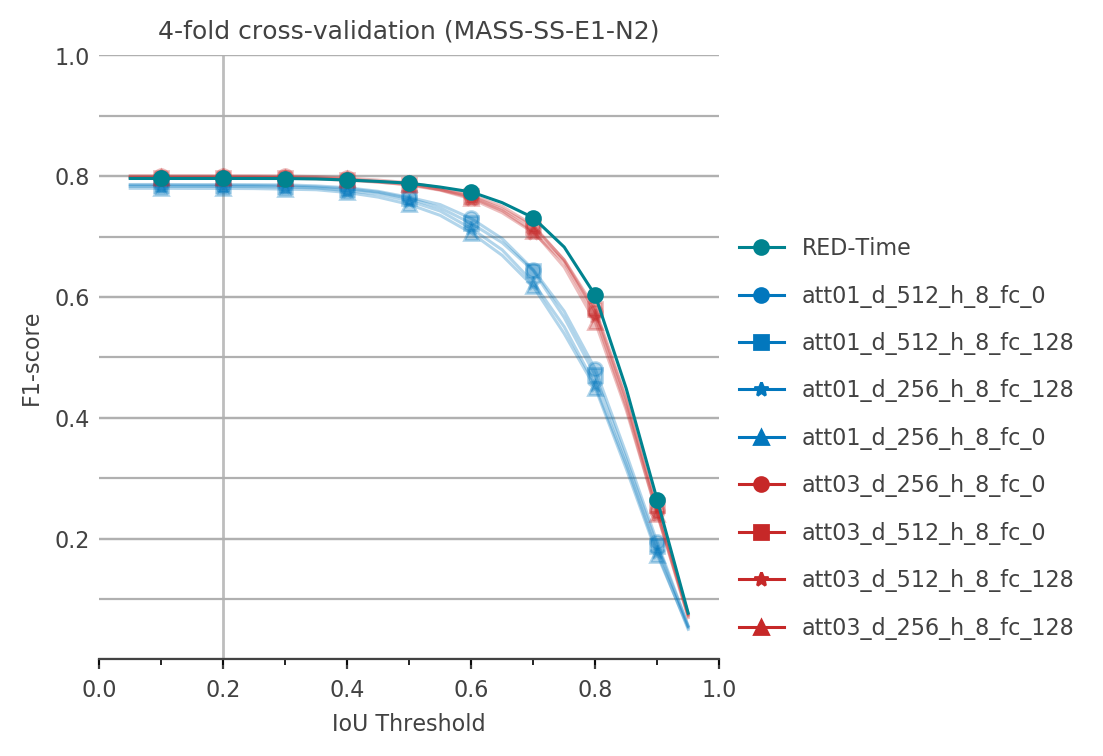

In [29]:
# plot
color_list = [viz.PALETTE['cyan']] + 4*[viz.PALETTE['blue']] + 4*[viz.PALETTE['red']]
# marker_list = 9*['o']
marker_list = ['o'] + 2*['o', 's', '*', '^']
# alpha_line_list = 9*[1]
alpha_line_list = [1.0] + 8*[0.3]
zorder_list = [30] + 8*[20]
idx_to_remove = []
# idx_to_remove = [0]
# idx_to_remove = [2, 3, 4, 5, 7, 8]

# Plot f1 vs iou specs
smaller_plot = False
external_legend = True
show_seed_std = False
alpha_seed_std = 0.4
alpha_expert = 0.5
iou_thr_to_show = 0.2
figsize = (4, 4)
title = '4-fold cross-validation (%s)' % result_id

# -------------------- P L O T ----------------------  
print('Database: %s, Expert: %d' % (dataset_name, which_expert))
print('IoU to show: %1.1f' % iou_thr_to_show)
this_dpi = 100 if smaller_plot else viz.DPI
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=this_dpi)

for i in range(n_cases):
    if i in idx_to_remove:
        continue
    this_label = ckpt_folder_list[i].split("/")[1]
    if this_label == 'v11':
        this_label = 'RED-Time'
    this_marker = marker_list[i]
    this_alpha = alpha_line_list[i]
    this_color = color_list[i]
    this_zorder = zorder_list[i]
    model_data_dict = data_dict_list[i]
    mean_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].mean(axis=0)
    std_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].std(axis=0)
    ax.plot(
        iou_curve_axis, mean_f1_vs_iou, linewidth=viz.LINEWIDTH, zorder=this_zorder, label=this_label,
        markersize=viz.MARKERSIZE, markevery=(1, 2),
        marker=this_marker, color=this_color, alpha=this_alpha
    )
    if show_seed_std:
        ax.fill_between(
            iou_curve_axis, mean_f1_vs_iou - std_f1_vs_iou, mean_f1_vs_iou + std_f1_vs_iou, 
            alpha=alpha_seed_std, facecolor=this_color, zorder=this_zorder)
    printer.print_performance_at_iou(model_data_dict, iou_thr_to_show, this_label)

ax.set_title(title, fontsize=viz.FONTSIZE_TITLE, loc='center')
ax = plotter.format_metric_vs_iou_plot(ax, 'F1-score', iou_thr_to_show)
lg = plotter.format_legend(ax, external_legend)
lg = plotter.set_legend_color(lg)
ax = plotter.set_axis_color(ax)
plt.show()